# MESSAGE-ix matrix improvement tool

This jupyter notebook is a prototype of the MESSAGE-ix matrix improvement tool.
This tool is aimed to automatically improve and optimize coefficient matrix quality for a MESSAGE-ix scenario and the used to return the results from scaled MESSAGE-ix matrix to the originally intended values.

This tool is derived from the tool developed by Makowski & Sosnowski, 1981 (https://pure.iiasa.ac.at/id/eprint/1766/1/CP-81-037.pdf)

According to Curtis and Reid (1972), matrix A can be described as well-scaled if:

$
\sum_{i} \sum_{j} \ (log_{10} \ |a_{i,j}|)^2 \leq v \qquad \qquad Eq. 1
$

with $v$ is an acceptable matrix quality criteria.
If $ax_{i,j}$ is $(log_{10} |a_{i,j}|)^2$ where $a_{i,j}$ is a non-zero value, matrix $Ax$ is:

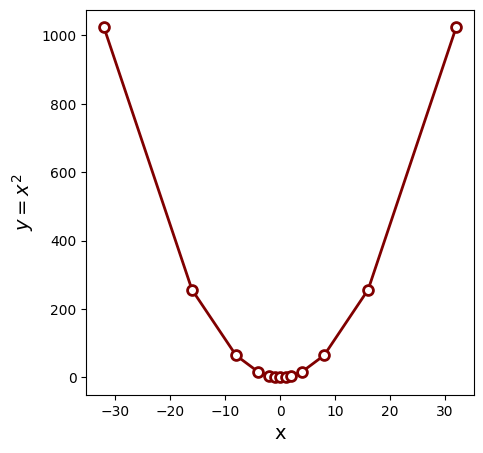

In [1]:
import numpy as np
import pandas as pd
from pyomo.environ import *
from datetime import datetime
import xarray as xr

import matplotlib.pyplot as plt

def showme(df):
    return df["val"].unstack()

# generating piecewise of x and y
x_pos = [2**x for x in range(0,6)]
x_neg = x_pos.copy()
x_neg.reverse()
x_neg = [-e for e in x_neg]

x = x_neg + [0] + x_pos
y = [np.power(e,2) for e in x]

# populating gradient and intercept for each line segment
linparams = {n: {'G':[], 'I': []} for n in range(1,len(x))}
for n in linparams.keys():
    M = (y[n]-y[n-1])/(x[n]-x[n-1])
    C = y[n-1] - M*x[n-1]
    linparams[n]['G'] = M # M
    linparams[n]['I'] = C # C

# create dataframe of gradient and intercept
df_linparams = pd.DataFrame(linparams).transpose()

fig, ax = plt.subplots(figsize=(5,5))

break_value = ax.scatter(x,y, marker='o', s=50, c='white', edgecolor='maroon', lw=2, zorder=1, )
for n in df_linparams.index:
    x_lin = [x[n-1],x[n]]
    y_lin = [y[n-1],y[n]]
    linearized_value = ax.plot(x_lin,y_lin, c='maroon', lw=2, zorder=0)

ax.set_xlabel('x', size=14)
ax.set_ylabel(r'$y = x^2$', size=14)
plt.show()

In [2]:
# Load the whole matrix
matrix      = (pd.read_csv('matrix_transport problem.csv')
               .set_index(['row','col'],drop=True)[['val']])

# create a binary matrix for optimization coefficient
matrix_sbin = matrix.copy()
matrix_sbin.loc[matrix_sbin['val']!=0,'val'] = 1
matrix_sbin = matrix_sbin.astype(int)

## converting matrix_sbin to dictiony
dict_matrix_sbin = matrix_sbin['val'].to_dict()


In [3]:
showme(matrix)

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,1.0,1.8,2.500000e-09,1.400000e-08,1.7,2.5,1.8
demand(chicago),NaN,1.0,NaN,NaN,1.0,NaN,NaN
demand(new-york),NaN,NaN,1.000000e+00,NaN,NaN,1.0,NaN
demand(topeka),NaN,NaN,NaN,1.000000e+00,NaN,NaN,1.0
supply(san-diego),NaN,1.0,1.000000e+00,1.000000e+00,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,1.0,1.0,1.0


In [4]:
showme(matrix_sbin)

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,1.0,1.0,1.0,1.0,1.0,1.0,1.0
demand(chicago),NaN,1.0,NaN,NaN,1.0,NaN,NaN
demand(new-york),NaN,NaN,1.0,NaN,NaN,1.0,NaN
demand(topeka),NaN,NaN,NaN,1.0,NaN,NaN,1.0
supply(san-diego),NaN,1.0,1.0,1.0,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,1.0,1.0,1.0


In [5]:
# calculate log base 2 of the absolute value of the matrix
log_absmatrix = matrix.copy()
log_absmatrix.loc[log_absmatrix['val']!=0,'val']=(np.log2(
    np.absolute(
        log_absmatrix.loc[log_absmatrix['val']!=0,'val'])))

# converting log_absmatrix to dictiony
dict_log_absmatrix = log_absmatrix['val'].to_dict()

In [6]:
log_absmatrix["val"].unstack()

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,0.0,0.847997,-28.575425,-26.089998,0.765535,1.321928,0.847997
demand(chicago),NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
demand(new-york),NaN,NaN,0.000000,NaN,NaN,0.000000,NaN
demand(topeka),NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
supply(san-diego),NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000


## Matrix quality optimization problem
Matrix $Ax$ then may be adjusted to fulfill the matrix quality criterion in $Eq. 1$ through the use of scaling coefficient $r_{i}$ for row $i$ and $c_{j}$ for column $j$ to minimize the following objective function:

$
Min_{(r,c)}: \frac{1}{2} \sum_{i} \sum_{j} (log_{2} \ r_{i} \ c_{j} \ |a_{i,j}|)^2 \qquad \qquad Eq. 2
$

Let us define:

$
w_{i} = log_{2} \ r_{i} \\
z_{j} = log_{2} \ c_{j}
$

With $w$ and $z$ are positive integer variables, an optimization problem using the equivalent of $Eq. 2$ as objective function can be formulated as:

$
Min_{(w,j)}: \frac{1}{2} \sum_{i} \sum_{j} \ (w_{i} + z_{j} + log_{2} \ |a_{i,j}|)^2 \qquad \qquad Eq. 3 \\
S.t.: \\
\qquad     w_{i}, z_{j} \geq 0 \qquad \qquad Eq. 4 \\
\qquad     w_{i}, z_{j} \in Z \qquad \qquad Eq. 5
$

In [7]:
# Generate dictionary of log_absmatrix
log_absmatrix_data = dict_log_absmatrix
matrix_sbin_data = dict_matrix_sbin
row_name = list(set(matrix.index.get_level_values('row')))
col_name = list(set(matrix.index.get_level_values('col')))
lin_sgmt = list(df_linparams.index)

# print start time
start_time = datetime.now().time()
print("Start Time:", start_time)

## Declare model's name
model   = ConcreteModel('Matrix_Rescaling_Factor')

## Define sets
model.i = Set(initialize=row_name, doc='Rows')
model.j = Set(initialize=col_name, doc='Columns')
model.l = Set(initialize=lin_sgmt, doc='Segments')

## Define parameters
model.log_absmatrix = Param(model.i, model.j, initialize=log_absmatrix_data, default=0,
                            doc='log2 of absolute value of a(i,j)')
model.matrix_sbin   = Param(model.i, model.j, initialize=matrix_sbin_data, default=0,
                            doc='binary value for row and column coefficients a(i,j)')
model.lin_grad = Param(model.l, initialize=df_linparams['G'].to_dict(), 
                            doc='gradient')
model.lin_intr = Param(model.l, initialize=df_linparams['I'].to_dict(), 
                            doc='intercept')

## Define variables
model.Log2RSF  = Var(model.i, bounds=(-50,50), domain=Integers, doc='Row scaling factor') # domain='PositiveIntegers'
model.Log2CSF  = Var(model.j, bounds=(-50,50), domain=Integers, doc='Column scaling factor')
model.LS_obj   = Var(model.i, model.j, bounds=(0,None), doc='Linearized substitute of objective function')

## Define constraints
def linobj_rule(model, i, j, l):
  return model.LS_obj[i,j] >= (model.lin_grad[l] * (- model.Log2RSF[i] + model.Log2CSF[j] + model.log_absmatrix[i,j])
                               + model.lin_intr[l])
model.linobj = Constraint(model.i, model.j, model.l, rule=linobj_rule, doc='Piece linearization of quadratic objective function')

def colobj_rule(model):
  return model.Log2CSF['constobj'] == 0
model.colobj = Constraint(rule=colobj_rule, doc='objective function column cannot be changed')

def rowobj_rule(model):
  return model.Log2RSF['_obj'] == 0
model.rowobj = Constraint(rule=rowobj_rule, doc='objective function column cannot be changed')


## Define objective function
def objective_rule(model):
   return (1/2)*sum(model.LS_obj[i,j] * model.matrix_sbin[i,j] for i in model.i for j in model.j)
model.objective = Objective(rule=objective_rule, sense=minimize, doc='Objective function')

if __name__ == '__main__':
    # This emulates what the pyomo command-line tools does
    from pyomo.opt import SolverFactory
    import pyomo.environ
    opt = SolverFactory("gams")
    opt.options['solver'] = 'cplex'
    results = opt.solve(model)
    print('Solution status   : ', results.solver.termination_condition)
    print('Objective function: ', model.objective(value))

    
# print finish time
finish_time = datetime.now().time()
print("Finish Time:", finish_time)


# collecting results
Log2RSFs = []
for i in row_name:
    Log2RSFs.append(model.Log2RSF[i](value))

Log2CSFs = []
for j in col_name:
    Log2CSFs.append(model.Log2CSF[j](value))
    
# Create dictionaries of row and column scalers
RSFs = dict(zip(row_name, [np.round(2**e,6) for e in Log2RSFs]))
CSFs = dict(zip(col_name, [np.round(2**e,6) for e in Log2CSFs]))

# Create dataframes for row and column scalers
row_scaler = pd.DataFrame(RSFs,index=['val']).transpose().rename_axis(index='row')
col_scaler = pd.DataFrame(CSFs,index=['val']).transpose().rename_axis(index='col')

# Create new_matrix dataframe for display
new_matrix = matrix.div(row_scaler,level=0).mul(col_scaler,level=1)

Start Time: 13:21:28.031574
Solution status   :  optimal
Objective function:  310.8452172597383
Finish Time: 13:21:28.276195


In [9]:
showme(matrix)

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,1.0,1.8,2.500000e-09,1.400000e-08,1.7,2.5,1.8
demand(chicago),NaN,1.0,NaN,NaN,1.0,NaN,NaN
demand(new-york),NaN,NaN,1.000000e+00,NaN,NaN,1.0,NaN
demand(topeka),NaN,NaN,NaN,1.000000e+00,NaN,NaN,1.0
supply(san-diego),NaN,1.0,1.000000e+00,1.000000e+00,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,1.0,1.0,1.0


In [10]:
showme(new_matrix)

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,1.0,230.400000,0.001311,0.00367,13.60,20.000000,14.400000
demand(chicago),NaN,4.000000,NaN,NaN,0.25,NaN,NaN
demand(new-york),NaN,NaN,256.000000,NaN,NaN,0.003906,NaN
demand(topeka),NaN,NaN,NaN,256.00000,NaN,NaN,0.007812
supply(san-diego),NaN,0.003906,16.000000,8.00000,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,1.00,1.000000,1.000000


In [11]:
scalers = [RSFs,CSFs]
prescale_args = {}
for s in scalers:
    for k,v in s.items():
        if k == '_obj':
            k_ = "_obj.scale"
        elif k == 'constobj':
            k_ = "constobj.scale"
        else:
            k_ = k.replace("(", ".scale('")
            k_ = k_.replace(")", "')")
            k_ = k_.replace(",", "','")
        prescale_args.update({k_:v})

gams_args = (str(prescale_args)
             .replace('{','')
             .replace('}','')
             .replace('"','')
             .replace(':','=')
             .replace(', ',';\n')
             +';'
            )

In [12]:
print(gams_args)

demand.scale('new-york')= 2048.0;
'_obj.scale'= 1.0;
supply.scale('seattle')= 8.0;
supply.scale('san-diego')= 32768.0;
demand.scale('topeka')= 1024.0;
demand.scale('chicago')= 32.0;
x.scale('seattle','new-york')= 8.0;
x.scale('san-diego','topeka')= 262144.0;
x.scale('seattle','chicago')= 8.0;
x.scale('seattle','topeka')= 8.0;
x.scale('san-diego','chicago')= 128.0;
x.scale('san-diego','new-york')= 524288.0;
'constobj.scale'= 1.0;


In [13]:
np.log2(524288.0)

19.0

In [14]:
# Printing stats

matrices_dict = {'Old Matrix':matrix,
                 'New Matrix':new_matrix,
                } 

for k,v in matrices_dict.items():
    print(f'{k} stats:')
    print('>> log10 coefficient range:',
          np.floor(np.log10(np.abs(v['val'].unstack()).fillna(1)).min(axis=None)),'--',
          np.floor(np.log10(np.abs(v['val'].unstack()).fillna(1)).max(axis=None)))
    print('')

# TO DO:
# 1. plot histogram of log10 distribution of those matrix


Old Matrix stats:
>> log10 coefficient range: -9.0 -- 0.0

New Matrix stats:
>> log10 coefficient range: -3.0 -- 2.0



(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 17.]),
 array([-8.60205999, -7.70205999, -6.80205999, -5.90205999, -5.00205999,
        -4.10205999, -3.20205999, -2.30205999, -1.40205999, -0.50205999,
         0.39794001]),
 <BarContainer object of 10 artists>)

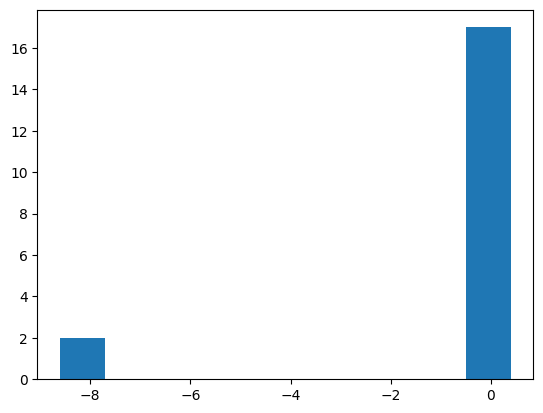

In [19]:
plt.hist(np.log10(matrix))

(array([4., 1., 0., 0., 1., 4., 1., 5., 0., 3.]),
 array([-2.88249007, -2.35341707, -1.82434407, -1.29527106, -0.76619806,
        -0.23712505,  0.29194795,  0.82102095,  1.35009396,  1.87916696,
         2.40823997]),
 <BarContainer object of 10 artists>)

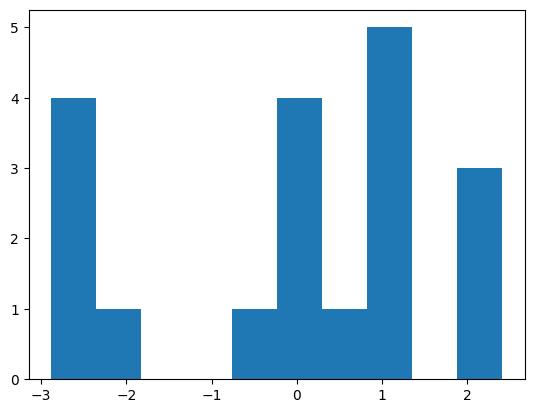

In [20]:
plt.hist(np.log10(new_matrix))